In [1]:
import os

import pandas as pd
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
def get_transcriptions(path):
    with open(path) as f:
        lines = f.read().split('\n')
        return lines

In [3]:
path = './data/segments/'

In [4]:
lines = get_transcriptions(path+'train.txt')
if (lines[-1]==''):
    lines = lines[:-1]
len(lines)

3550

In [5]:
def parser_line(line):
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = line.split('|')
    phoneme = phoneme.split(' ')
    note = note.split(' ')
    note_duration = [float(i) for i in note_duration.split(' ')]
    phoneme_duration = [float(i) for i in phoneme_duration.split(' ')]
    slur_note = [int(i) for i in slur_note.split(' ')]
    assert len(phoneme) == len(note_duration) and len(phoneme_duration) == len(slur_note) and len(slur_note) == len(phoneme)
    return id, text, phoneme, note, note_duration, phoneme_duration, slur_note


In [6]:
phoneme_set = set()
note_set = set()
for line in lines:
    id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(line)
    phoneme_set.update(set(phoneme))
    note_set.update(set(note))

In [7]:
# phoneme_set, note_set

In [8]:
line = lines[3549]
line

'2099003712|我的爱已降落|w o SP d e ai y i SP j iang l uo|F4 F4 rest F4 F4 E4 D4 D4 rest E4 E4 F4 F4|0.263560 0.263560 0.078530 0.448900 0.448900 0.291180 1.209190 1.209190 0.805550 0.854130 0.854130 1.851400 1.851400|0.1313 0.13226 0.07853 0.14925 0.29965 0.29118 0.2753 0.93389 0.80555 0.10491 0.74922 0.28334 1.56806|0 0 0 0 0 0 0 0 0 0 0 0 0'

In [9]:
id, text, phoneme, note, note_duration, phoneme_duration, slur_note = parser_line(line)

In [21]:
initial_table = ['b', 'p', 'm', 'f',
                'd', 't', 'n', 'l',
                'g', 'k', 'h',
                'j', 'q', 'x',
                'zh', 'ch', 'sh', 'r', 'z', 'c', 's', 'y', 'w']
def merge_note(text, phoneme, note, note_duration):
    # remove the duplicate items in phoneme, note, and note_duration
    # use text to verify the length
    phoneme = phoneme.copy()
    note = note.copy()
    note_duration = note_duration.copy()
    for i in range(len(phoneme)-1, 0, -1):
        if note_duration[i] == note_duration[i-1] and phoneme[i-1] in initial_table:
            del note_duration[i]
            del note[i]
            phoneme[i-1]=phoneme[i-1]+phoneme[i]
            del phoneme[i]
    j = 0
    text_with_p = phoneme.copy()
    for i in range(len(text_with_p)):
        if text_with_p[i] not in ['AP', 'SP']:
            text_with_p[i] = text[j]
            j+=1
    return text_with_p, phoneme, note, note_duration
    
# merge_note(text, phoneme, note, note_duration)

In [22]:
# for i in [id, text, phoneme, note, note_duration, phoneme_duration, slur_note]:
#     print(len(i))

In [23]:
def get_audio(id, path, sr = 16000):
    wav_path = path+'wavs/'+id+'.wav'
    waveform, sample_rate = torchaudio.load(wav_path)
    if sample_rate != sr:
        waveform = torchaudio.functional.resample(waveform[0].unsqueeze(0), sample_rate, sr)
    return waveform

waveform = get_audio(id, path)

In [24]:
sum(phoneme_duration), waveform.shape[-1]/16000

(5.80244, 5.8025)

In [25]:
import matplotlib as mpl
print (mpl.matplotlib_fname())



/scratch/bh2283/penv/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc


torch.Size([128, 182])


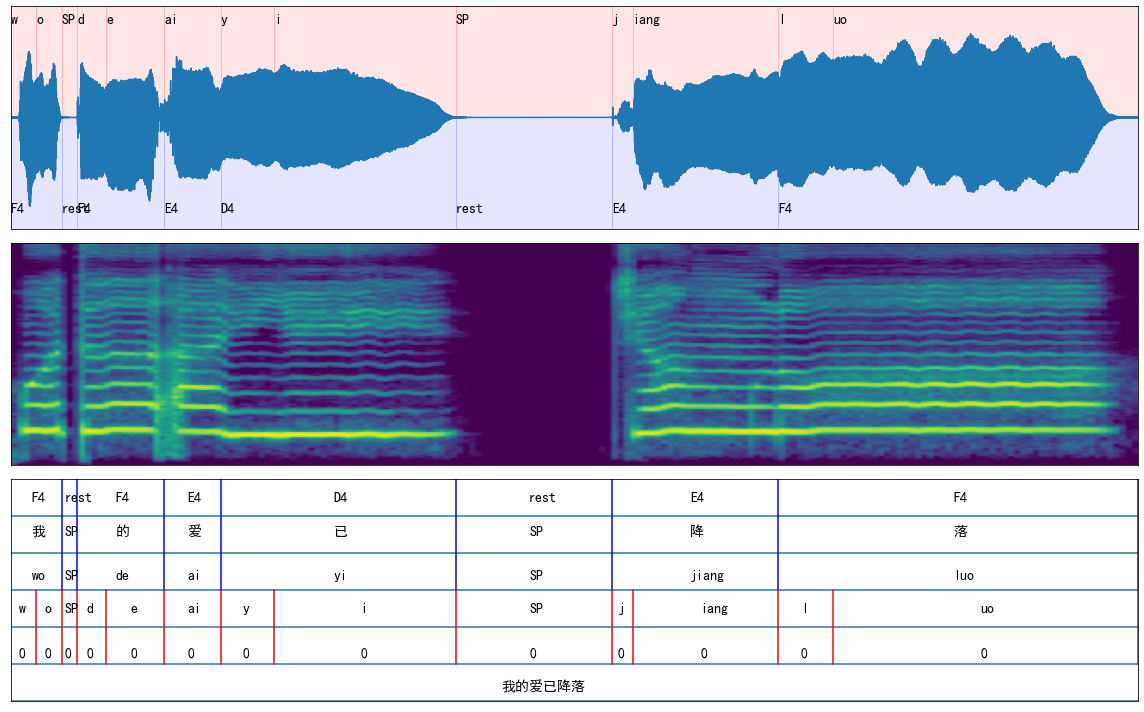

In [43]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = ['SimHei']
# # mpl.rcParams['font.sans-serif'] = ['SimHei, Droid Sans']
# mpl.rcParams['axes.unicode_minus'] = False
import librosa
def melspec(waveform, sr=16000):
    n_fft = 1024
    win_length = None
    hop_length = 512
    n_mels = 128
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm='slaney',
        onesided=True,
        n_mels=n_mels,
        mel_scale="htk",
    )
    melspec = mel_spectrogram(waveform)
    return melspec

def plot_alignment(waveform, text, phoneme, note, note_duration, phoneme_duration, slur_note, sr=16000):
    fontsize = 14
    text_with_p, phoneme_merge, note, note_duration = merge_note(text, phoneme, note, note_duration)
    fig, ax = plt.subplots(3, 1, figsize=(16, 10))
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    [ax1, ax2, ax3] = ax
    # ax1 wave form
    ratio = sr
    ax1.plot(waveform/(max(torch.max(waveform), -torch.min(waveform)))*0.8)
    ax1.set_xlim(0, waveform.size(-1))
    ax1.set_ylim(-1.0, 1.0)
    time_current = 0.
    for i in range(len(phoneme_duration)):
        x0 = ratio * time_current
        time_current += phoneme_duration[i]
        x1 = ratio * time_current
        ax1.axvspan(x0, x1, ymin=0.5, ymax=1, alpha=0.1, color="red")
        ax1.annotate(phoneme[i], (x0, 0.85), color='black', fontsize=fontsize)
    time_current = 0
    for i in range(len(note_duration)):
        x0 = ratio * time_current
        time_current += note_duration[i]
        x1 = ratio * time_current
        ax1.axvspan(x0, x1, ymin=0, ymax=0.5, alpha=0.1, color="blue")
        ax1.annotate(note[i].split('/')[0], (x0, -0.85), color='black', fontsize=fontsize)

    
    mel = melspec(waveform)
    ax2.imshow(librosa.power_to_db(mel) , origin='lower', aspect='auto')
    print(mel.shape)
    # ax2.set_xlim(0, mel.size(-1))

    ax3.set_ylim(-1.0, 1.0)
    ax3.set_xlim(0, waveform.size(-1))
    y_split = lambda k: [1.0*(i)/k for i in range(k)]
    k = 6
    ys = y_split(k)
    for i in range(k):
        ax3.axhline(y=ys[i]*2-1)
    # notes *3 
    time_current = 0
    for i in range(len(note_duration)):
        x0 = ratio * time_current
        time_current += note_duration[i]
        x1 = ratio * time_current
        ax3.axvline(x=x1, ymin=ys[3], ymax=1, color="blue")
        ax3.annotate(note[i].split('/')[0], (x0+(note_duration[i]-0.05)*ratio/2, 0.8), color='black', fontsize=fontsize)
        ax3.annotate(text_with_p[i], (x0+(note_duration[i]-0.05)*ratio/2, 0.5), color='black', fontsize=fontsize)
        ax3.annotate(phoneme_merge[i], (x0+(note_duration[i]-0.05)*ratio/2, 0.1), color='black', fontsize=fontsize)
    phoneme *2
    time_current = 0
    for i in range(len(phoneme_duration)):
        x0 = ratio * time_current
        time_current += phoneme_duration[i]
        x1 = ratio * time_current
        ax3.axvline(x=x1, ymin=ys[1], ymax=ys[3], color="red")
        ax3.annotate(phoneme[i], (x0+(phoneme_duration[i]-0.05)*ratio/2, -0.2), color='black', fontsize=fontsize)
        ax3.annotate(slur_note[i], (x0+(phoneme_duration[i]-0.05)*ratio/2, -0.6), color='black', fontsize=fontsize)
    ax3.annotate(text, ((sum(phoneme_duration)-len(text)/8)*ratio/2, -0.9), color='black', fontsize=fontsize)
    fig.tight_layout()


plot_alignment(waveform[0], text, phoneme, note, note_duration, phoneme_duration, slur_note)
plt.show()